# PixelSHAP: Understanding What Your Vision Model Sees

Ever wondered which parts of an image your AI model actually cares about? PixelSHAP reveals the hidden importance of every object in your images using game theory (SHAP values).

**Think of it like this:** If your image is a team, PixelSHAP tells you which players are MVPs for answering specific questions.

## Setup & Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# Add parent directory to path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from token_shap.base import OpenAIEmbeddings, OpenAIModel
from token_shap.pixel_shap import PixelSHAP
from token_shap.image_utils import (
    YoloSam2SegmentationModel, 
    DinoSam2SegmentationModel, 
    GenericInstanceSegmentationModel,
    BlackoutSegmentationManipulator
)
from token_shap.visualization import visualize_segmentation_results

print("Ready to analyze images!")

Ready to analyze images!


## 🔧 Configuration

In [2]:
# Your OpenAI API key (replace with your own)
#api_key = (...)
# Initialize the vision model and embeddings
vlm = OpenAIModel(model_name='gpt-4o', api_key=api_key)
openai_embedding = OpenAIEmbeddings(model="text-embedding-3-large", api_key=api_key)

# Manipulator for hiding objects (we'll black them out)
manipulator = BlackoutSegmentationManipulator(mask_type='bbox', preserve_overlapping=True)

## Example 1: YOLO + SAM2 - Traffic Analysis

Let's analyze a traffic scene and figure out which vehicle the model thinks is losing control.

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 44.3ms
Speed: 3.3ms preprocess, 44.3ms inference, 75.0ms postprocess per image at shape (1, 3, 352, 640)
Found 8 objects: {'person', 'truck', 'car'}


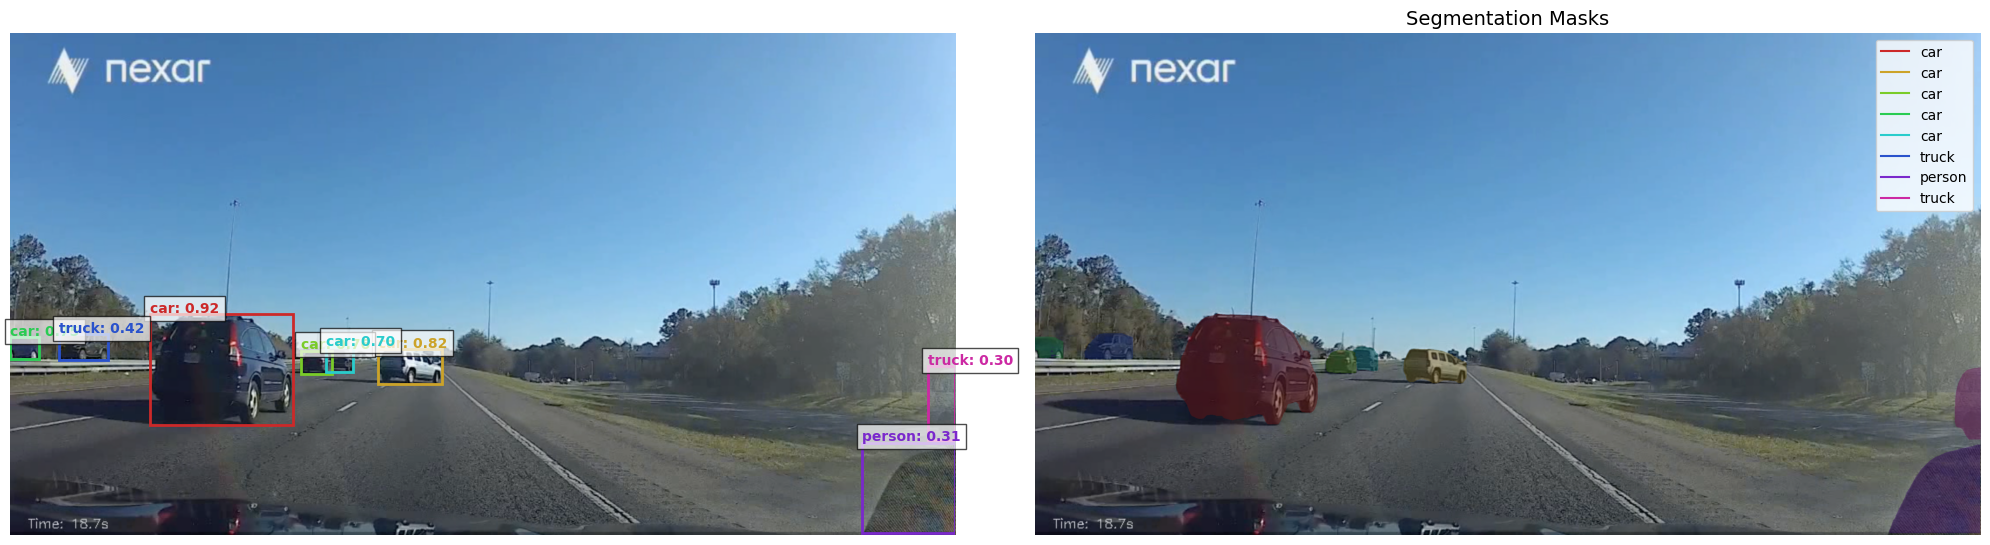

In [3]:
# Initialize YOLO segmentation
segmentation_model = YoloSam2SegmentationModel(
    yolo_model_path="yolov8x.pt",
    sam2_model_id="facebook/sam2.1-hiera-large",
    conf_threshold=0.2,
    device="cuda",
    use_yolov8=True,
)

# Segment the image
image_path = 'images/nexar_1.png'
boxes, labels, confidences, masks = segmentation_model.segment(image_path=image_path)
print(f"Found {len(labels)} objects: {set(labels)}")
visualize_segmentation_results(image_path, boxes, labels, confidences, masks)

In [4]:
# Create PixelSHAP analyzer
pixel_shap = PixelSHAP(
    model=vlm,
    segmentation_model=segmentation_model,
    manipulator=manipulator,
    vectorizer=openai_embedding
)

# Analyze: Which vehicle loses control?
results_df, shapley_values = pixel_shap.analyze(
    image_path=image_path,
    prompt="Which vehicle loses control?",
    sampling_ratio=0.5,
    max_combinations=20,
    cleanup_temp_files=False
)


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 12.0ms
Speed: 1.5ms preprocess, 12.0ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 9.5ms postprocess per image at shape (1, 3, 352, 640)


In [5]:
results_df.head()

Combination_Key  \
0  combination_2,3,4,5,6,7,8   
1  combination_1,3,4,5,6,7,8   
2  combination_1,2,4,5,6,7,8   
3  combination_1,2,3,5,6,7,8   
4  combination_1,2,3,4,6,7,8   

                                    Used_Combination Hidden_Objects  \
0  [car_1, car_2, car_3, car_4, truck_5, person_6...        [car_0]   
1  [car_0, car_2, car_3, car_4, truck_5, person_6...        [car_1]   
2  [car_0, car_1, car_3, car_4, truck_5, person_6...        [car_2]   
3  [car_0, car_1, car_2, car_4, truck_5, person_6...        [car_3]   
4  [car_0, car_1, car_2, car_3, truck_5, person_6...        [car_4]   

                                            Response                Indexes  \
0  The white SUV in the center of the image appea...  (2, 3, 4, 5, 6, 7, 8)   
1  I can't determine which vehicle loses control ...  (1, 3, 4, 5, 6, 7, 8)   
2  The white SUV on the right appears to be losin...  (1, 2, 4, 5, 6, 7, 8)   
3  The white SUV in the right lane is the vehicle...  (1, 2, 3, 5, 6, 7, 8)   
4  I can't determine which vehicle loses control ...  (1, 2, 3, 4, 6, 7, 8)   

   Similarity  
0    0.840408  
1    0.597225  
2    0.922801  
3    0.882717  
4    0.566663


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 16.4ms
Speed: 1.4ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


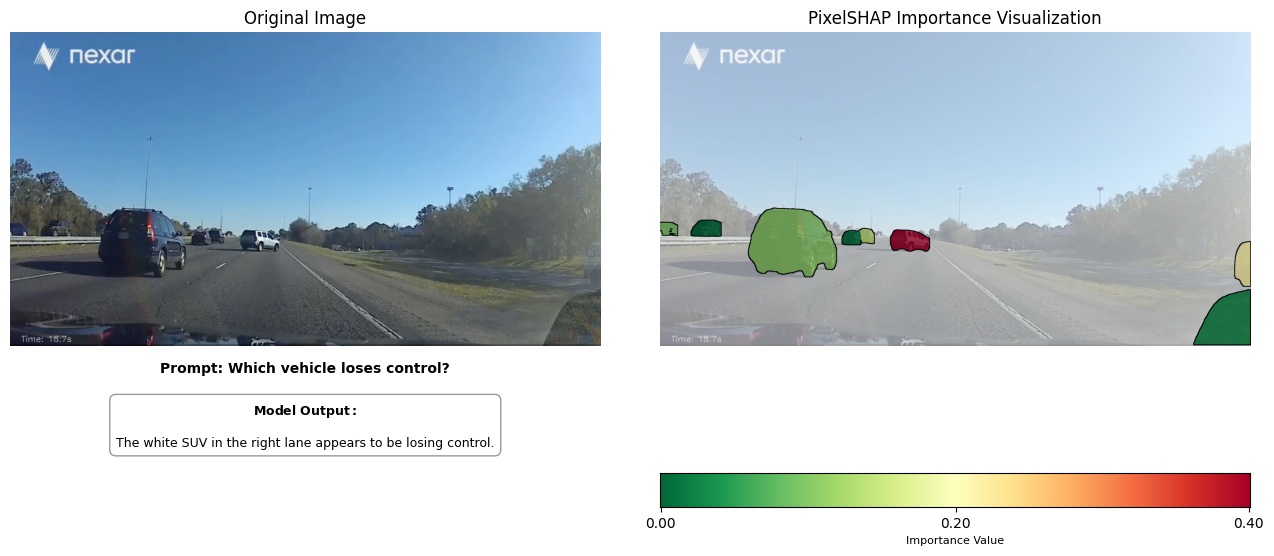

In [6]:
# Visualize the importance heatmap
pixel_shap.visualize(
    background_opacity=0.5,
    show_original_side_by_side=True,
    show_labels=False,
    show_model_output=True
)


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/nexar_1.png: 352x640 1 person, 5 cars, 2 trucks, 26.4ms
Speed: 1.7ms preprocess, 26.4ms inference, 9.7ms postprocess per image at shape (1, 3, 352, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:310: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


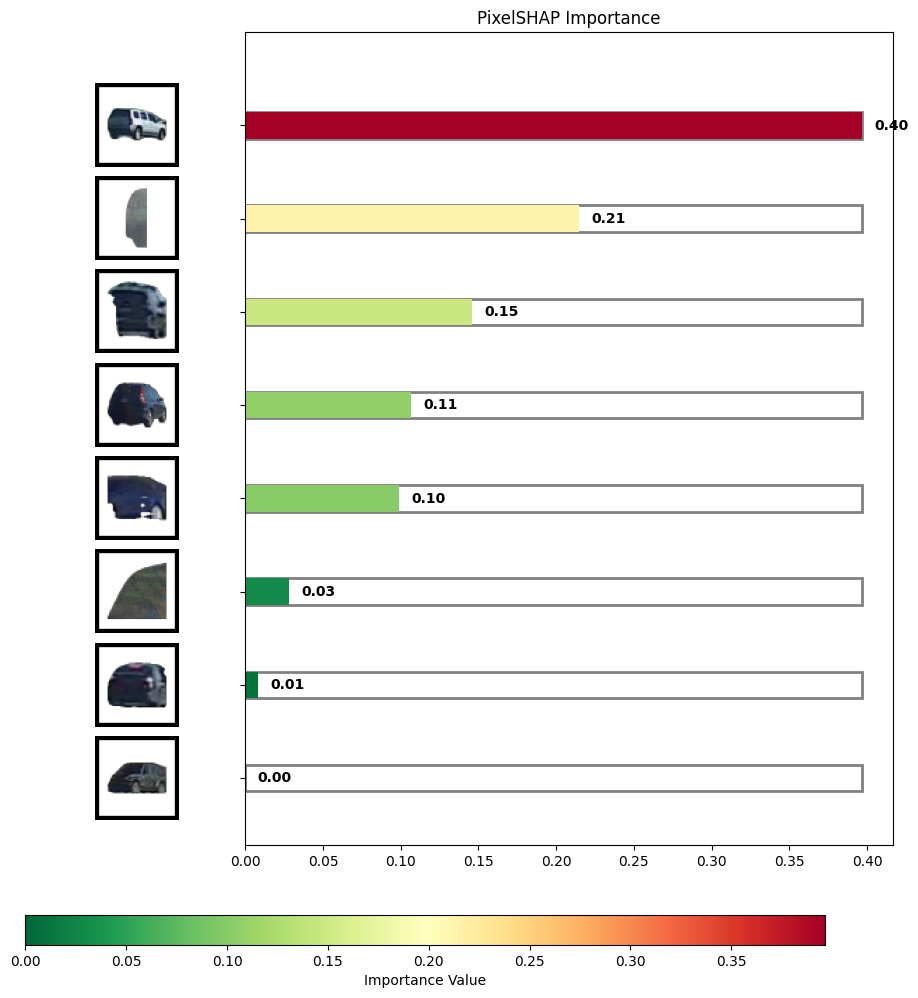

In [7]:
# Show importance ranking with thumbnails
sorted_items = pixel_shap.plot_importance_ranking(thumbnail_size=10)

### Testing how the model focuses on different image regions based on the question asked.


Question: Which item in the picture needs watering?

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.7ms
Speed: 6.1ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 28.6ms
Speed: 3.8ms preprocess, 28.6ms inference, 4.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 34.7ms
Speed: 2.5ms preprocess, 34.7ms inference, 9.6ms postprocess per image at shape (1, 3, 448, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


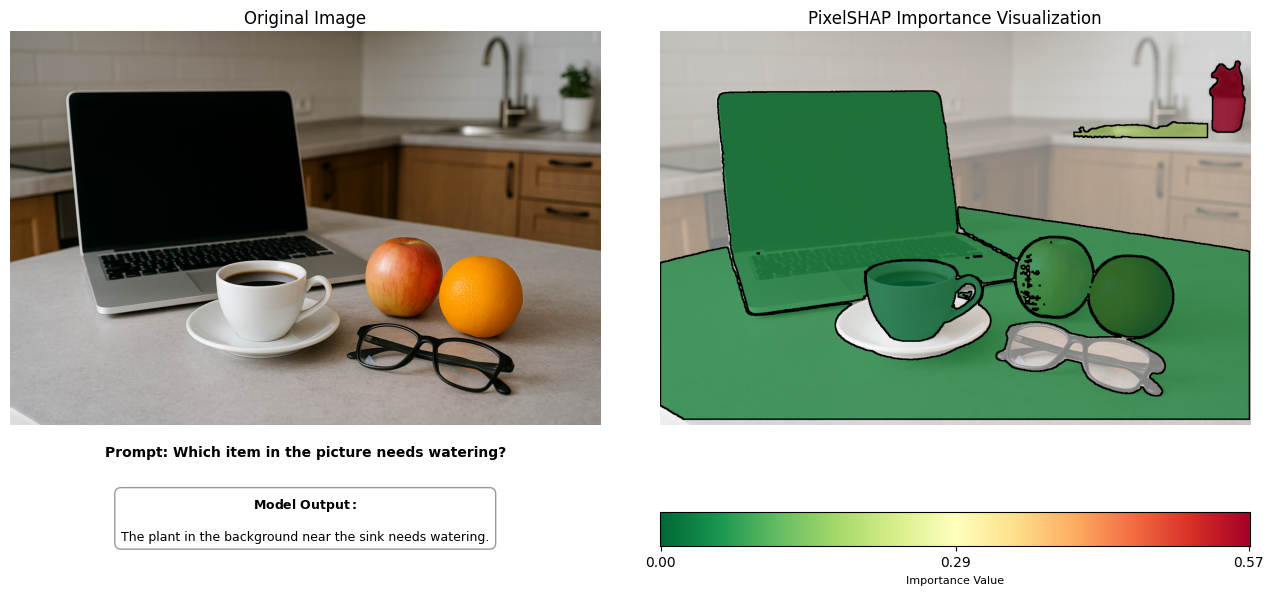


Question: What drink is in the picture?

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 30.9ms
Speed: 2.1ms preprocess, 30.9ms inference, 9.5ms postprocess per image at shape (1, 3, 448, 640)


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.8ms
Speed: 1.5ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


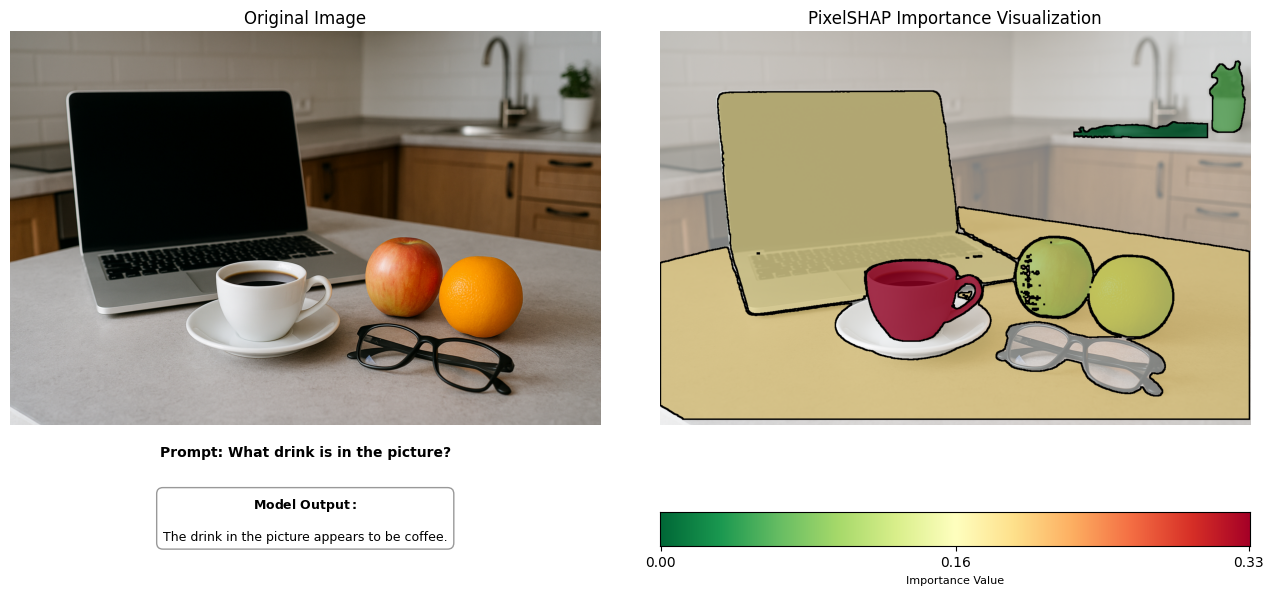


Question: What fruit is next to the computer?

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]


image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/ubuntu/TokenSHAP/notebooks/images/general.png: 448x640 1 cup, 1 apple, 1 orange, 1 potted plant, 1 dining table, 1 laptop, 1 sink, 10.7ms
Speed: 1.6ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


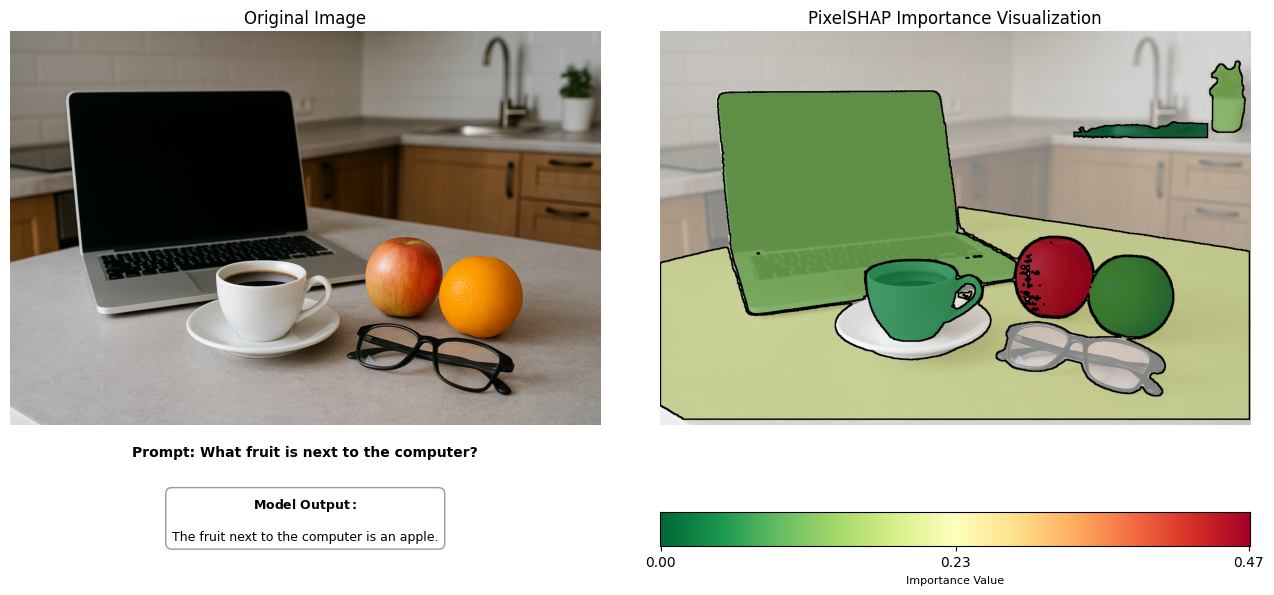

In [9]:
questions = [
    "Which item in the picture needs watering?",
    "What drink is in the picture?",
    "What fruit is next to the computer?", 
]

# Run analysis for each question
results = []
for question in questions:
    print(f"\nQuestion: {question}")
    
    result_df, shapley_values = pixel_shap.analyze(
        image_path='images/general.png',
        prompt=question,
        sampling_ratio=0.5,
        max_combinations=20,
        cleanup_temp_files=False
    )
    
    results.append((question, result_df, shapley_values))
    
    # Visualize
    pixel_shap.visualize(
        background_opacity=0.5,
        show_original_side_by_side=True,
        show_labels=False,
        show_model_output=True
    )

## Example 2: Text-Prompted Detection with Grounding DINO

Sometimes you want to look for specific objects. Grounding DINO lets you describe what to find with text!

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/tokenshap/lib/python3.10/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


Grounding DINO found: [('car truck', '0.37'), ('car truck', '0.39'), ('car', '0.43'), ('car', '0.41'), ('car', '0.30'), ('car truck', '0.45'), ('car truck', '0.34'), ('person', '0.27'), ('car', '0.28'), ('car', '0.27'), ('car', '0.28'), ('car truck', '0.25')]


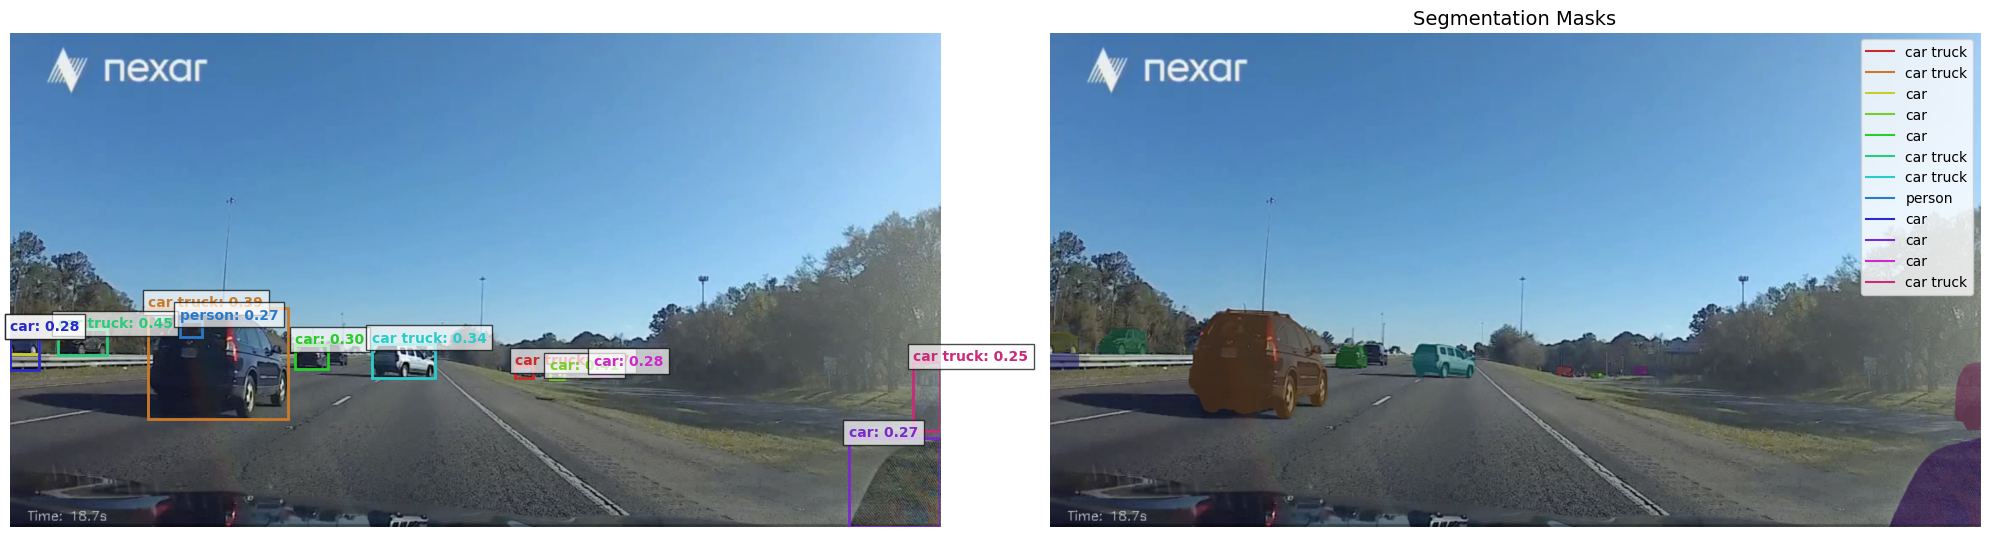

In [8]:
# Initialize Grounding DINO with text prompt
dino_segmentation = DinoSam2SegmentationModel(
    text_prompt="car, truck, person, traffic light",
    grounding_dino_model="IDEA-Research/grounding-dino-tiny",
    sam2_model_id="facebook/sam2.1-hiera-large",
    device="cuda",
    box_threshold=0.25,
    text_threshold=0.15,
)

# Test on the traffic image
boxes_dino, labels_dino, conf_dino, masks_dino = dino_segmentation.segment(image_path=image_path)
print(f"Grounding DINO found: {list(zip(labels_dino, [f'{c:.2f}' for c in conf_dino]))}")
visualize_segmentation_results(image_path, boxes_dino, labels_dino, conf_dino, masks_dino)

Processing combinations:   0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/envs/tokenshap/lib/python3.10/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)
/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


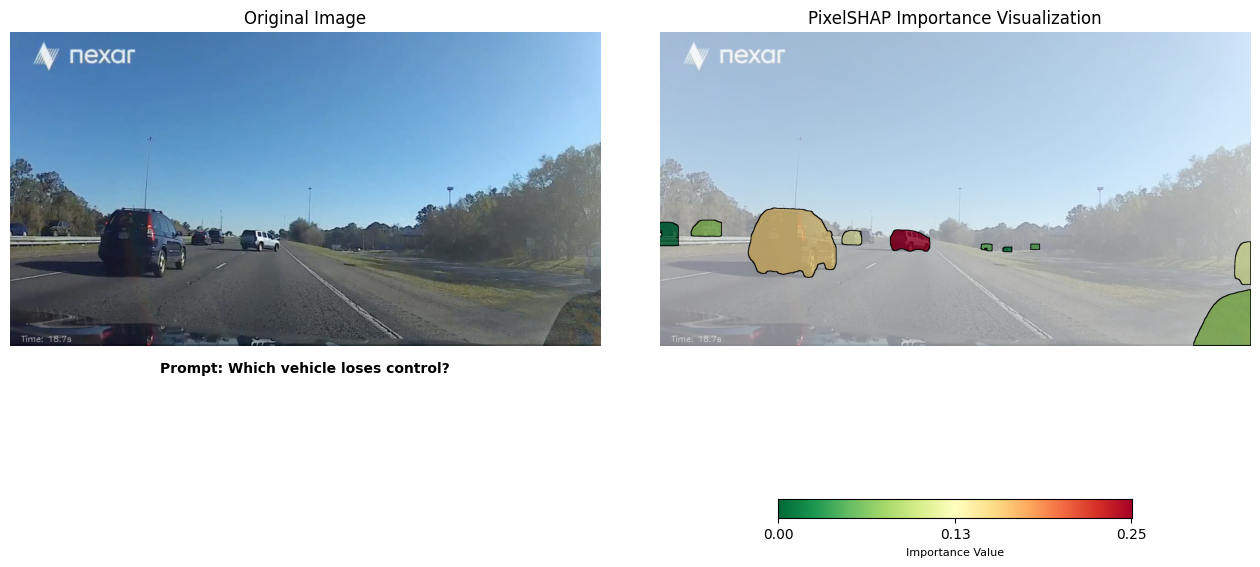

In [9]:
# Quick PixelSHAP analysis with DINO
pixel_shap_dino = PixelSHAP(
    model=vlm,
    segmentation_model=dino_segmentation,
    manipulator=manipulator,
    vectorizer=openai_embedding
)

results_dino, _ = pixel_shap_dino.analyze(
    image_path=image_path,
    prompt="Which vehicle loses control?",
    sampling_ratio=0.5,
    max_combinations=20
)

# Heatmap visualization
pixel_shap_dino.visualize(
    background_opacity=0.5,
    show_original_side_by_side=True,
    heatmap_style=True
)

## Example 3: Analyzing Cat Behavior

Let's switch to something fun - figuring out which cat is being mischievous!

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/tokenshap/lib/python3.10/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


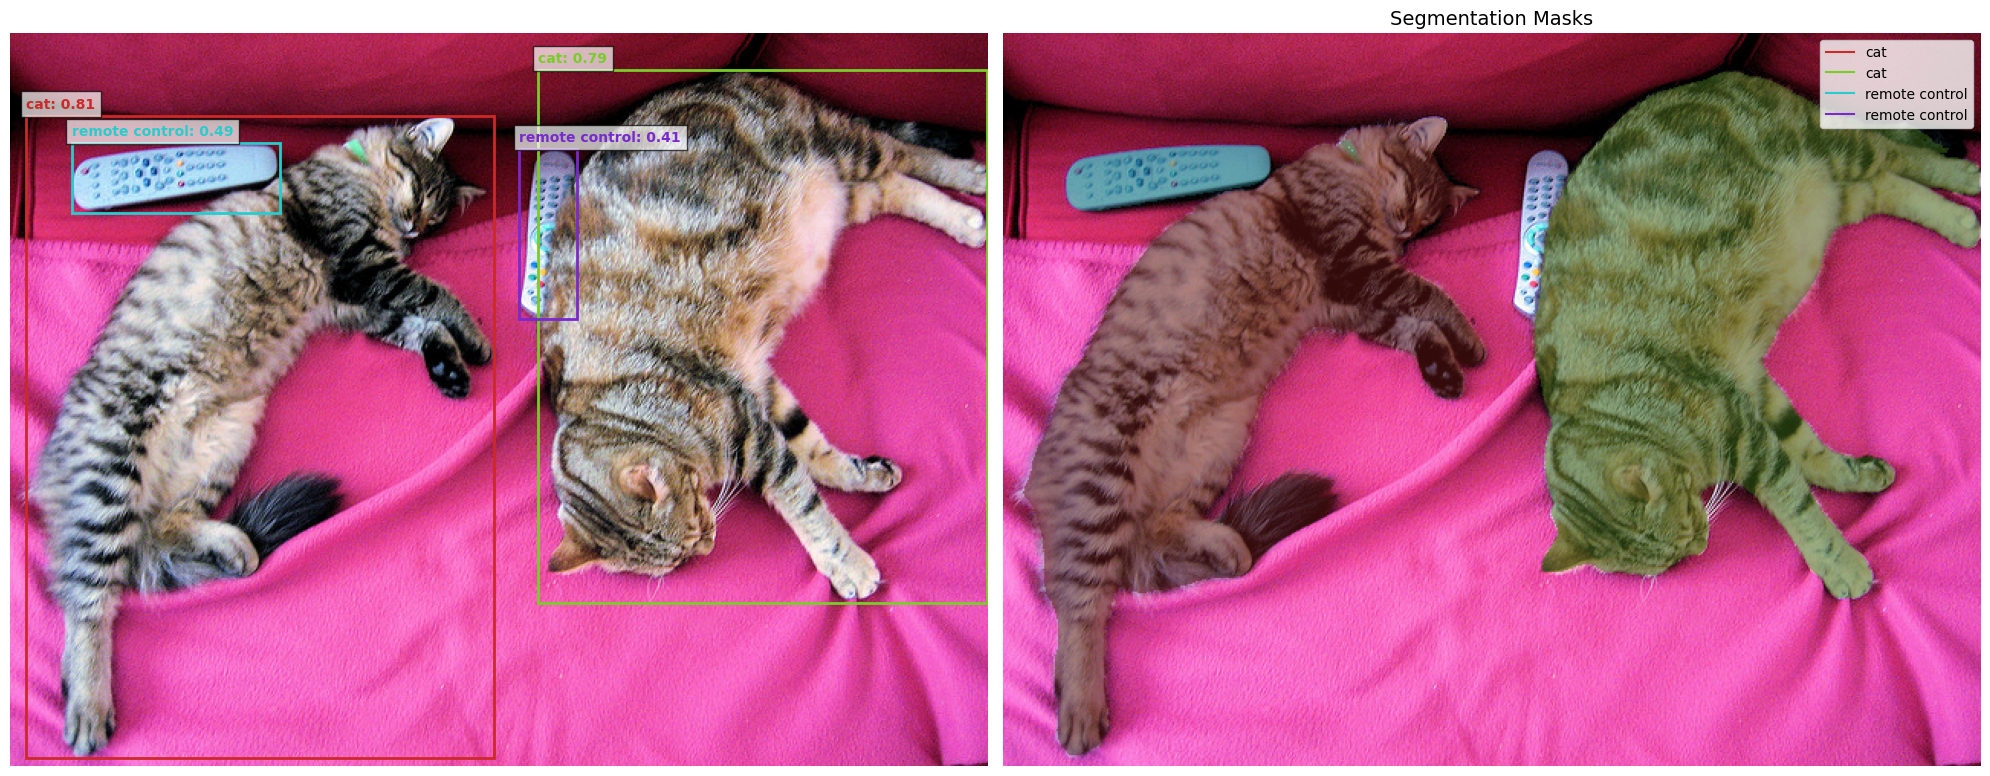

Processing combinations:   0%|          | 0/9 [00:00<?, ?it/s]

/opt/conda/envs/tokenshap/lib/python3.10/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)
/home/ubuntu/TokenSHAP/token_shap/visualization.py:814: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # First apply tight layout
/home/ubuntu/TokenSHAP/token_shap/visualization.py:1029: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


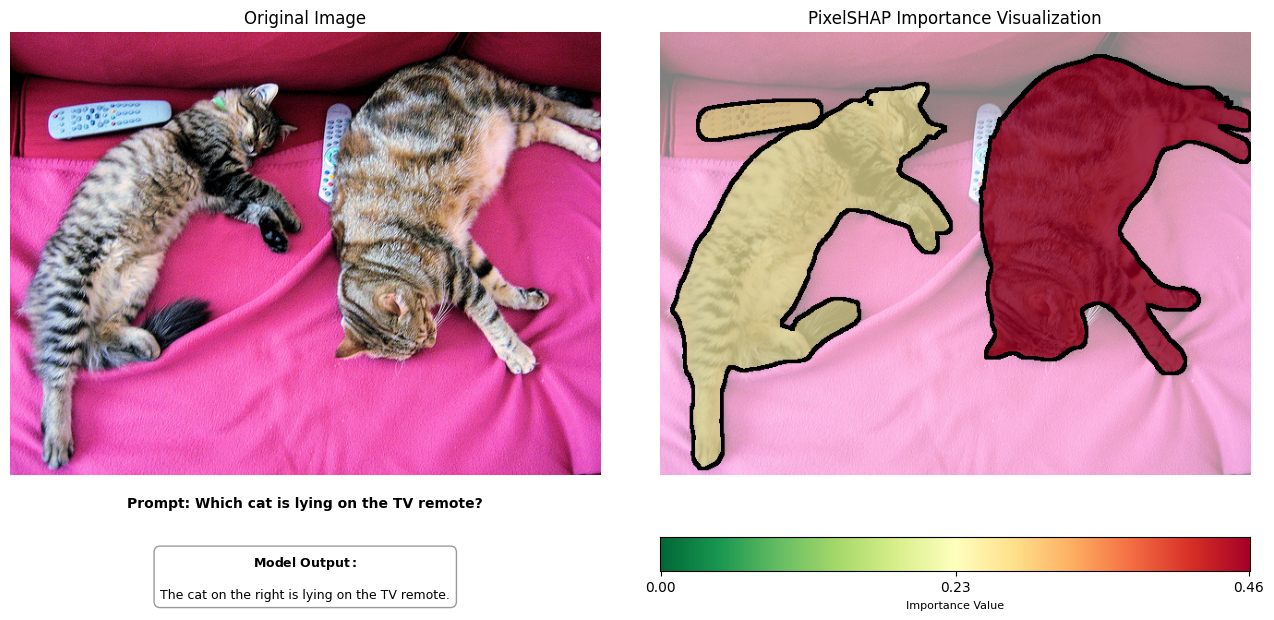

In [3]:
# Cat-specific detection
cat_image = "images/000000039769.jpg"

cat_segmentation = DinoSam2SegmentationModel(
    text_prompt="cat, remote control",
    grounding_dino_model="IDEA-Research/grounding-dino-tiny",
    sam2_model_id="facebook/sam2.1-hiera-large",
    device="cuda",
    box_threshold=0.2,
    text_threshold=0.15,
)

# Detect cats and remote
boxes_cat, labels_cat, conf_cat, masks_cat = cat_segmentation.segment(cat_image)
visualize_segmentation_results(cat_image, boxes_cat, labels_cat, conf_cat, masks_cat)

# Which cat is hiding the remote?
pixel_shap_cat = PixelSHAP(
    model=vlm,
    segmentation_model=cat_segmentation,
    manipulator=manipulator,
    vectorizer=openai_embedding,
    temp_dir='example_temp_cat',
)

results_cat, _ = pixel_shap_cat.analyze(
    image_path=cat_image,
    prompt="Which cat is lying on the TV remote?",
    sampling_ratio=0.5,
    max_combinations=20
)

pixel_shap_cat.visualize(
    background_opacity=0.5,
    show_original_side_by_side=True,
    show_labels=False,
    show_model_output=True
)

## 💡 Tips & Tricks

### Getting Better Results:
- **Lower thresholds** = more objects detected (but possibly noise)
- **Higher sampling_ratio** = more accurate SHAP values (but slower)
- **Different manipulators** = try blur or inpainting instead of blackout

### Debugging:
- Set `debug=True` in PixelSHAP to see what's happening
- Check `temp_dir` folder to see the manipulated images
- If no objects detected, adjust detection thresholds

### Performance:
- Use `cleanup_temp_files=True` to save disk space
- Reduce `max_combinations` for faster analysis
- Use smaller models (tiny vs large) for speed